In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
def plot_series(series, time_index=None, ax=None, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", xticks_num=10):
    plt.plot(series, ".-")
    extend_hl = 0

    if ax is None:
        ax = plt

    if y is not None:
        if hasattr(y, 'size'):
            extend_hl = max(extend_hl, y.size)
            n_steps = np.arange(y.size)+series.size
        elif isinstance(y, tf.Tensor):
            extend_hl = max(extend_hl, y.numpy().size)
            n_steps = np.arange(y.numpy().size)+series.size

        plt.plot([series.size-1, series.size], [series[-1], y[0]], '.-b')
        plt.plot(n_steps, y, "-bx", markersize=10, label='true')

    if y_pred is not None:
        if hasattr(y_pred, 'size'):
            extend_hl = max(extend_hl, y_pred.size)
            n_steps = np.arange(y_pred.size)+series.size
        elif isinstance(y_pred, tf.Tensor):
            extend_hl = max(extend_hl, y_pred.numpy().size)
            n_steps = np.arange(y_pred.numpy().size)+series.size
        print(series.size-1)
        print(series.size)
        print(series[-1])
        print(series[0])
        plt.plot([series.size-1, series.size], [series[-1], y_pred[0]], '.-r')
        plt.plot(n_steps, y_pred, "-ro", label='pred')

    plt.grid(True)

    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)

    if time_index is not None:
        plt.xticks(np.linspace(0, time_index.size-1, xticks_num),
                   ['{:.02f}'.format(x) for x in np.linspace(0, time_index[-1], xticks_num)])
        plt.axis([0, time_index.size-1, -1, 1])

    plt.hlines(0, 0, series.size+extend_hl, linewidth=1)

    if y is not None or y_pred is not None:
        plt.legend()


In [3]:
file_path = r'D:\code\AI\final_project\data.csv'

df = pd.read_csv(file_path, header=None).to_numpy()
# X_train = df[:7000, :-2]
# y_train = df[:7000, -2]
# X_valid = df[7000:9000, :-2]
# y_valid = df[7000:9000, -2]
# X_test = df[9000:, :-2]
# y_test = df[9000:, -2]

X_train = df[:7000, :16]
y_train = df[:7000, 16:-2]
X_valid = df[7000:9000, :16]
y_valid = df[7000:9000, 16:-2]
X_test = df[9000:, :16]
y_test = df[9000:, 16:-2]

X_train = X_train[:, :, tf.newaxis]
X_valid = X_valid[:, :, tf.newaxis]
X_test  = X_test [:, :, tf.newaxis]



## model

In [4]:
def make_model(units = 15, depth = 1):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.SimpleRNN(units ,return_sequences=True, input_shape =[None, 1]))
    model.add(tf.keras.layers.SimpleRNN(units, return_sequences=True))
    model.add(tf.keras.layers.SimpleRNN(units))
    model.add(tf.keras.layers.Dense(depth))
    
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [5]:
model = make_model(15, 15)
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, verbose=1, restore_best_weights=True)]

history = model.fit(X_train, y_train, epochs = 1000, validation_data = (X_valid, y_valid),batch_size = 2048, callbacks= callbacks)

plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/1000
4/4 [==============================] - 3s 200ms/step - loss: 54.7369 - val_loss: 52.6948
Epoch 2/1000
4/4 [==============================] - 0s 78ms/step - loss: 54.0752 - val_loss: 52.0996
Epoch 3/1000
4/4 [==============================] - 0s 71ms/step - loss: 53.4908 - val_loss: 51.5870
Epoch 4/1000
4/4 [==============================] - 0s 80ms/step - loss: 52.9769 - val_loss: 51.1199
Epoch 5/1000
4/4 [==============================] - 0s 65ms/step - loss: 52.5061 - val_loss: 50.6938
Epoch 6/1000
4/4 [==============================] - 0s 66ms/step - loss: 52.0754 - val_loss: 50.3088
Epoch 7/1000
4/4 [==============================] - 0s 80ms/step - loss: 51.6860 - val_loss: 49.9530
Epoch 8/1000
4/4 [==============================] - 0s 67ms/step - loss: 51.3241 - val_loss: 49.6130
Epoch 9/1000
4/4 [==============================] - 0s 77ms/step - loss: 50.9737 - val_loss: 49.2846
Epoch 10/1000
4/4 [==============================] - 0s 68ms/step - loss: 50.6378 - val_lo

KeyboardInterrupt: 

In [9]:
model.save('model0517.h5')


In [5]:
model = tf.keras.models.load_model(r"D:\code\AI\final_project\model0517.h5")

32/32 [==============================] - 1s 17ms/step
(1000, 15)
(1000, 15)
MSE: 38.910187
15
16
[2.]
[3.]


c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


IndexError: invalid index to scalar variable.

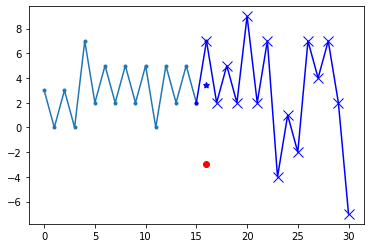

In [17]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred)).numpy())


test_num = 5
pred_num = 15
# plt.plot(range(31), X_test[test_num,:])
# plt.scatter([31], y_test[test_num], color = 'red')
# plt.scatter([31], y_pred[test_num], color = 'blue', marker=(5,1))
plt.scatter([31-15], y_test[test_num][14], color = 'red')
plt.scatter([31-15], y_pred[test_num][14], color = 'blue', marker=(5,1))
plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred[0][0])